https://www.techscience.com/iasc/v36n1/49992/html
- 50 Epoch
- Batch Size 20
- Image size of 416

**References:**
1. https://www.youtube.com/watch?v=Ciy1J97dbY0&ab_channel=LearnOpenCV
2. https://learnopencv.com/custom-object-detection-training-using-yolov5/
3. https://github.com/spmallick/learnopencv/tree/master/Custom-Object-Detection-Training-using-YOLOv5
4. https://colab.research.google.com/github/spmallick/learnopencv/blob/master/Custom-Object-Detection-Training-using-YOLOv5/Custom_Object_Detection_using_YOLOv5.ipynb

# **Import Libraries**

In [ ]:
import os
import collections
import glob as glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
import requests
import random
import numpy as np
import pandas as pd
import yaml
from PIL import Image
import torch
import pickle
from datetime import datetime
import shutil
from IPython.display import Image, display

np.random.seed(42)

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

# **Data Preparation**

## **Download Dataset**
Dataset di-download dari Huggingface. Di dalam Google Colab, dataset akan terstruktur seperti ini:

```
├── data.yaml
├── README.dataset.txt
├── README.roboflow.txt
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

```

In [ ]:
# Variable untuk link/url dataset
dataset_url="https://universe.roboflow.com/ds/SlQeB1URih?key=ID9muzCTOt"

In [ ]:
# Untuk download dan unzip dataset
if not os.path.exists('train'):
    !curl -L $dataset_url > yolov5_data.zip; unzip yolov5_data.zip; rm yolov5_data.zip
    
    dirs = ['train', 'valid', 'test']

    for i, dir_name in enumerate(dirs):
        all_image_names = sorted(os.listdir(f"{dir_name}/images/"))
        for j, image_name in enumerate(all_image_names):
            if (j % 2) == 0:
                file_name = image_name.split('.jpg')[0]
                os.remove(f"{dir_name}/images/{image_name}")
                os.remove(f"{dir_name}/labels/{file_name}.txt")

Streaming output truncated to the last 5000 lines.
 extracting: train/labels/004215_jpg.rf.9710d34f1eb79dc4ffae912e8ef13ddc.txt  
 extracting: train/labels/004215_jpg.rf.f208097589c36ad64cf8e64ac754fd62.txt  
 extracting: train/labels/004216_jpg.rf.0c8a3b5285257f284112091e7b8bd3f2.txt  
 extracting: train/labels/004216_jpg.rf.50d226b81288c6c90474769b607e86ca.txt  
 extracting: train/labels/004216_jpg.rf.ec794574e2f996ec897b44851f56c699.txt  
 extracting: train/labels/004217_jpg.rf.404f638fc9e82b412ab4fcc492378c3c.txt  
 extracting: train/labels/004217_jpg.rf.901e8a4b652a5bebfb219379fc21cfaa.txt  
 extracting: train/labels/004217_jpg.rf.b28705e13ee76ec0033d812610e60a2b.txt  
 extracting: train/labels/004218_jpg.rf.64e519c9560ecbd97aaee0f8893d8599.txt  
 extracting: train/labels/004218_jpg.rf.8a11edc70c07faab707cefce544f96b1.txt  
 extracting: train/labels/004218_jpg.rf.8eeafd0b6d93bf380d69ef946feebb2c.txt  
 extracting: train/labels/004219_jpg.rf.940d3250d4865106e7b6ab2db1375e13.txt  
 

## **Edit yaml**
Edit data.yaml supaya path-nya sesuai dengan yang ada di Google Colab

In [ ]:
%%writetemplate /content/data.yaml
train: /content/train/images
val: /content/valid/images
test: /content/test/images

nc: 2
names: ['no-helmet', 'helmet']

## **Define Classes**
Definisikan kelas-kelas dalam dataset


In [ ]:
# Load the YAML file
with open('data.yaml') as file:
    data_yaml = yaml.safe_load(file)

# Extract the class names into a list
class_names = data_yaml['names']
# Extract the number of classes based on data.yaml
num_classes = data_yaml['nc']

# Print the list of class names
display(num_classes)
display(class_names)

2

['no-helmet', 'helmet']

In [ ]:
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

## **Convert Bounding Box Coordinates into Absolute**
Fungsi-fungsi di bawah akan mengkonversikan koordinat relatif pada label dataset menjadi koordinat absolut yang sesuai dengan ukuran gambar.

Sebagai contoh, misal isi file .txt pada label adalah:
```
12 0.3890625 0.6609375 0.12734375 0.209375
```
- 12 menandakan kelas
- 0.3890625 adalah xmin
- 0.6609375 adalah ymin
- 0.12734375 adalah xmax
- 0.209375 adalah ymax



In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

xmin, ymin, xmax, dan ymax akan dikalikan dengan ukuran dari gambar untuk mendapatkan koordinat absolut. Misal ukuran gambar adalah 416 x 416, akan menjadi:
- xmin: 161
- ymin: 274
- xmax: 53
- ymax: 87

# **Data Exploration**

## **Visualize Sample Training Data**

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                data = label_line.split(' ')
                label = int(data[0])
                bbox_values = list(map(float, data[1:]))  # convert to float
                bboxes.append(bbox_values)
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

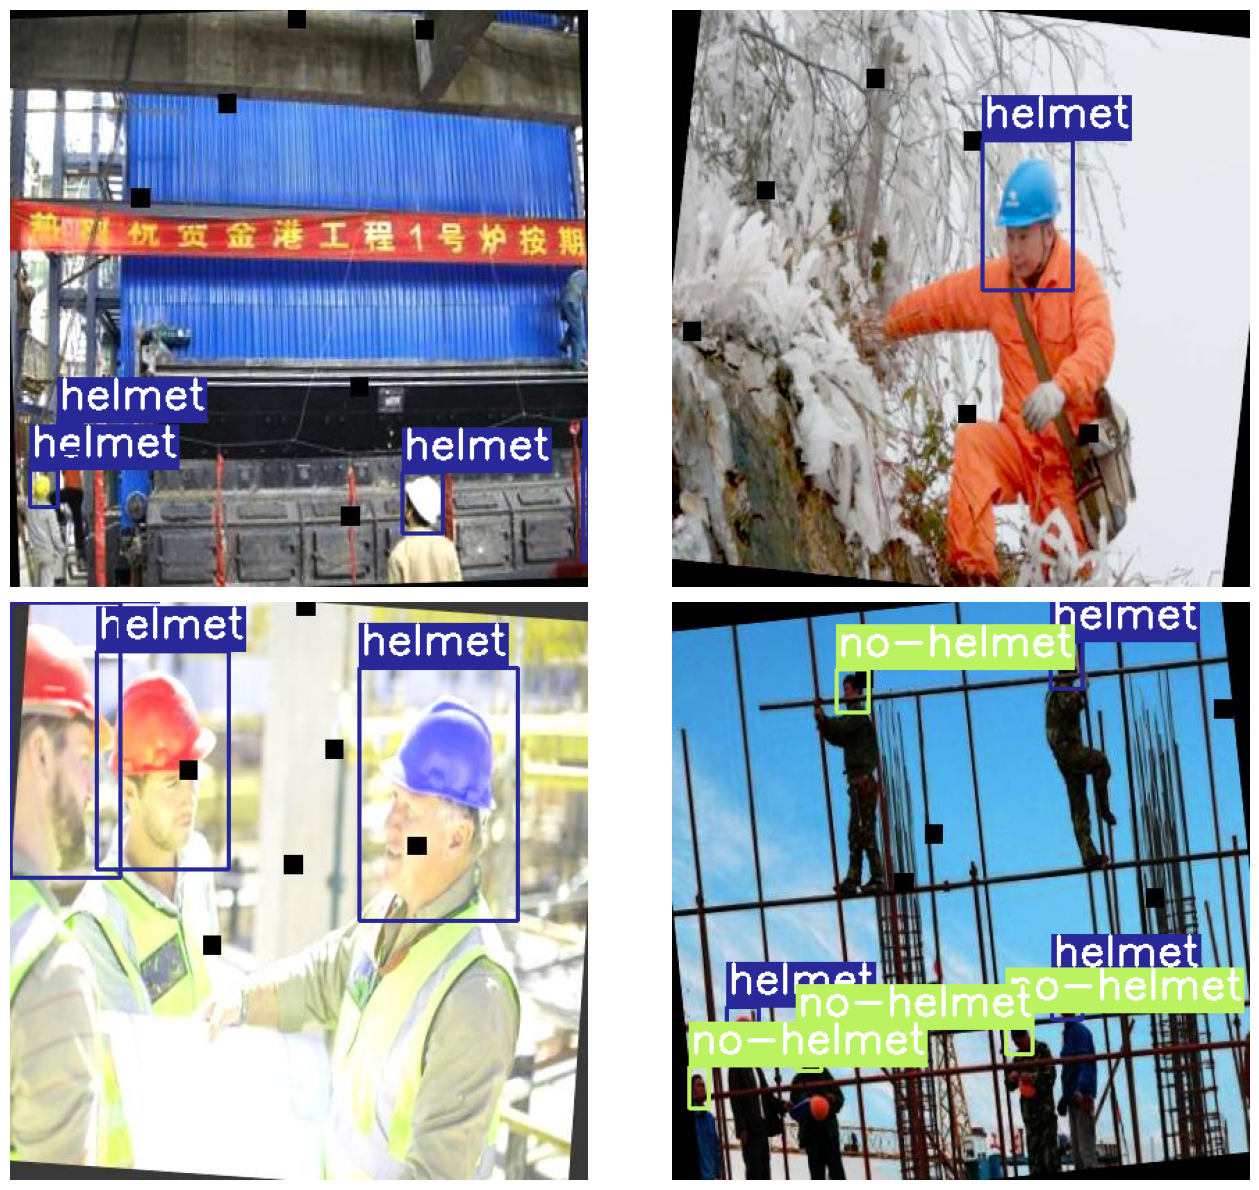

In [ ]:
# Visualize a few training images.
plot(
    image_paths='train/images/*', 
    label_paths='train/labels/*',
    num_samples=4,
)

## **Train, Validation, Test Data Distribution**
Menampilkan jumlah data pada tiap folder train, valid, dan test.

In [ ]:
def count_files(directory_path):
    # Ensures that the counted entries are files, not directories
    return len([entry for entry in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, entry))])

# Define the paths
train_path = '/content/train/images'
val_path = '/content/valid/images'
test_path = '/content/test/images'

# Count the images in each directory
train_images_count = count_files(train_path)
valid_images_count = count_files(val_path)
test_images_count = count_files(test_path)

total_count = train_images_count + valid_images_count + test_images_count

# Create a DataFrame
df = pd.DataFrame({
    'Directory': ['Train', 'Valid', 'Test', 'Total'],
    'Image Count': [train_images_count, valid_images_count, test_images_count, total_count]
})

# Display the DataFrame
display(df)

Directory  Image Count
0     Train         7374
1     Valid          706
2      Test          353
3     Total         8433

## **Class Distribution**
Menampilkan sebaran data untuk tiap kelas pada data train, validation, dan test



In [ ]:
def count_class_ids(dirs):
    class_id_counter = collections.Counter()

    for directory in dirs:
        # Walk through all files in the directory that includes subdirectories
        for dirpath, _, files in os.walk(directory):
            for filename in files:

                # Only read .txt files
                if filename.endswith('.txt'):
                    with open(os.path.join(dirpath, filename)) as file:

                        # Read each line in the file
                        for line in file.readlines():
                            class_id = int(line.split()[0])
                            class_id_counter[class_id] += 1

    return class_id_counter

# Define directories
directories = ['train/labels', 'valid/labels', 'test/labels']

# Count class IDs in the defined directories
class_counts = count_class_ids(directories)

# Sort the class IDs
sorted_counts = {k: class_counts[k] for k in sorted(class_counts)}

# Load the YAML file
with open('data.yaml') as file:
    data_yaml = yaml.safe_load(file)

# Extract the class names into a list
class_names = data_yaml['names']

# Convert to DataFrame
df = pd.DataFrame(list(sorted_counts.items()), columns=['Class ID', 'Count'])

# Check for missing classes
missing_classes = [class_name for i, class_name in enumerate(class_names) if i not in df['Class ID'].values]
if missing_classes:
    print(f"Missing classes: {missing_classes}")
else:
    print("All classes are present in the data.")

# Add class names column to DataFrame
df['Class Name'] = [class_names[i] for i in df['Class ID']]

# Set Class ID as index
df.set_index('Class ID', inplace=True)

# Calculate total count and append to the DataFrame
total_count = df['Count'].sum()
total_df = pd.DataFrame({'Count': total_count, 'Class Name': 'Total'}, index=[''])
df = pd.concat([df, total_df])

# Display the DataFrame
display(df)


All classes are present in the data.


Count Class Name
0   7786  no-helmet
1  23672     helmet
   31458      Total

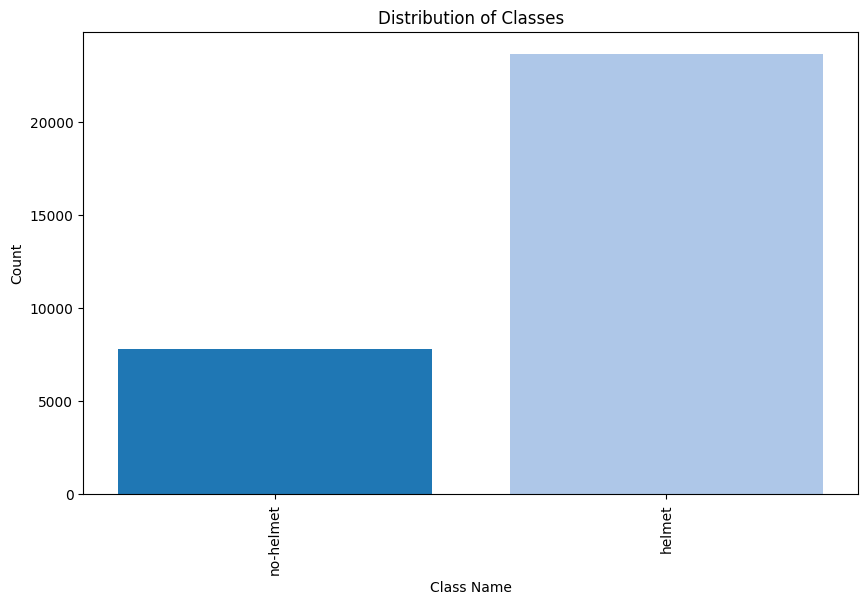

In [ ]:
def plot_class_distribution(df, use_color=True):
    plt.figure(figsize=(10, 6))  # Set the figure size

    # Create a vertical bar plot
    if use_color:
        plt.bar(df['Class Name'][:-1], df['Count'][:-1], color=mpl.cm.tab20.colors[:14])
    else:
        plt.bar(df['Class Name'][:-1], df['Count'][:-1])

    # Add labels and title
    plt.xlabel('Class Name')
    plt.ylabel('Count')
    plt.title('Distribution of Classes')

    # Rotate class names on the x-axis for better readability
    plt.xticks(rotation=90)

    # Display the plot
    plt.show()

# Usage
plot_class_distribution(df, use_color=True)

# **Install BestYOLO**
Setelah men-download dataset, kita akan men-download BestYOLO. Struktur folder akan menjadi seperti ini:

```
├── data.yaml
├── README.dataset.txt
├── README.roboflow.txt
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
├── valid
│   ├── images
│   └── labels
└── BestYOLO
    ├── data
    ├── models
    └── utils

```

### **Clone BestYOLO Repository**

In [ ]:
# clone YOLOv5 repository
%cd /content/
!git clone https://github.com/WangRongsheng/BestYOLO.git  # clone repo
%cd BestYOLO

/content
Cloning into 'BestYOLO'...
remote: Enumerating objects: 896, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 896 (delta 52), reused 17 (delta 17), pack-reused 780
Receiving objects: 100% (896/896), 55.89 MiB | 18.09 MiB/s, done.
Resolving deltas: 100% (403/403), done.
/content/BestYOLO


### **Install Requirements and Dependencies**

In [ ]:
# install dependencies as necessary
!pip install -r requirements.txt  # install dependencies (ignore errors)
import torch
from BestYOLO import utils

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.1 MB/s eta 0:00:00
Setup complete. Using torch 2.0.1+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


# **Training Model**

## **Edit train.py**

In [ ]:
%%writefile /content/BestYOLO/train.py
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
"""
Train a YOLOv5 model on a custom dataset.
Models and datasets download automatically from the latest YOLOv5 release.

Usage - Single-GPU training:
    $ python train.py --data coco128.yaml --weights yolov5s.pt --img 640  # from pretrained (recommended)
    $ python train.py --data coco128.yaml --weights '' --cfg yolov5s.yaml --img 640  # from scratch

Usage - Multi-GPU DDP training:
    $ python -m torch.distributed.run --nproc_per_node 4 --master_port 1 train.py --data coco128.yaml --weights yolov5s.pt --img 640 --device 0,1,2,3

Models:     https://github.com/ultralytics/yolov5/tree/master/models
Datasets:   https://github.com/ultralytics/yolov5/tree/master/data
Tutorial:   https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data
"""

import argparse
import math
import os
import random
import sys
import time
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import torch
import torch.distributed as dist
import torch.nn as nn
import yaml
from torch.optim import lr_scheduler
from tqdm import tqdm

FILE = Path(__file__).resolve()
ROOT = FILE.parents[0]  # YOLOv5 root directory
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

import val as validate  # for end-of-epoch mAP
from models.experimental import attempt_load
from models.yolo import Model
from utils.autoanchor import check_anchors
from utils.autobatch import check_train_batch_size
from utils.callbacks import Callbacks
from utils.dataloaders import create_dataloader
from utils.downloads import attempt_download, is_url
from utils.general import (LOGGER, TQDM_BAR_FORMAT, check_amp, check_dataset, check_file, check_git_info,
                           check_git_status, check_img_size, check_requirements, check_suffix, check_yaml, colorstr,
                           get_latest_run, increment_path, init_seeds, intersect_dicts, labels_to_class_weights,
                           labels_to_image_weights, methods, one_cycle, print_args, print_mutation, strip_optimizer,
                           yaml_save)
from utils.loggers import Loggers
from utils.loggers.comet.comet_utils import check_comet_resume
from utils.loss import ComputeLoss
from utils.loss_OTA import ComputeLossOTA
from utils.metrics import fitness
from utils.plots import plot_evolve
from utils.torch_utils import (EarlyStopping, ModelEMA, de_parallel, select_device, smart_DDP, smart_optimizer,
                               smart_resume, torch_distributed_zero_first)

LOCAL_RANK = int(os.getenv('LOCAL_RANK', -1))  # https://pytorch.org/docs/stable/elastic/run.html
RANK = int(os.getenv('RANK', -1))
WORLD_SIZE = int(os.getenv('WORLD_SIZE', 1))
GIT_INFO = check_git_info()


def train(hyp, opt, device, callbacks):  # hyp is path/to/hyp.yaml or hyp dictionary
    save_dir, epochs, batch_size, weights, single_cls, evolve, data, cfg, resume, noval, nosave, workers, freeze, loss_OTA = \
        Path(opt.save_dir), opt.epochs, opt.batch_size, opt.weights, opt.single_cls, opt.evolve, opt.data, opt.cfg, \
        opt.resume, opt.noval, opt.nosave, opt.workers, opt.freeze, opt.loss_OTA
    callbacks.run('on_pretrain_routine_start')

    # Directories
    w = save_dir / 'weights'  # weights dir
    (w.parent if evolve else w).mkdir(parents=True, exist_ok=True)  # make dir
    last, best = w / 'last.pt', w / 'best.pt'

    # Hyperparameters
    if isinstance(hyp, str):
        with open(hyp, errors='ignore') as f:
            hyp = yaml.safe_load(f)  # load hyps dict
    LOGGER.info(colorstr('hyperparameters: ') + ', '.join(f'{k}={v}' for k, v in hyp.items()))
    opt.hyp = hyp.copy()  # for saving hyps to checkpoints

    # Save run settings
    if not evolve:
        yaml_save(save_dir / 'hyp.yaml', hyp)
        yaml_save(save_dir / 'opt.yaml', vars(opt))

    # Loggers
    data_dict = None
    if RANK in {-1, 0}:
        loggers = Loggers(save_dir, weights, opt, hyp, LOGGER)  # loggers instance

        # Register actions
        for k in methods(loggers):
            callbacks.register_action(k, callback=getattr(loggers, k))

        # Process custom dataset artifact link
        data_dict = loggers.remote_dataset
        if resume:  # If resuming runs from remote artifact
            weights, epochs, hyp, batch_size = opt.weights, opt.epochs, opt.hyp, opt.batch_size

    # Config
    plots = not evolve and not opt.noplots  # create plots
    cuda = device.type != 'cpu'
    init_seeds(opt.seed + 1 + RANK, deterministic=True)
    with torch_distributed_zero_first(LOCAL_RANK):
        data_dict = data_dict or check_dataset(data)  # check if None
    train_path, val_path = data_dict['train'], data_dict['val']
    nc = 1 if single_cls else int(data_dict['nc'])  # number of classes
    names = {0: 'item'} if single_cls and len(data_dict['names']) != 1 else data_dict['names']  # class names
    is_coco = isinstance(val_path, str) and val_path.endswith('coco/val2017.txt')  # COCO dataset

    # Model
    check_suffix(weights, '.pt')  # check weights
    pretrained = weights.endswith('.pt')
    if pretrained:
        with torch_distributed_zero_first(LOCAL_RANK):
            weights = attempt_download(weights)  # download if not found locally
        ckpt = torch.load(weights, map_location='cpu')  # load checkpoint to CPU to avoid CUDA memory leak
        model = Model(cfg or ckpt['model'].yaml, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # create
        exclude = ['anchor'] if (cfg or hyp.get('anchors')) and not resume else []  # exclude keys
        csd = ckpt['model'].float().state_dict()  # checkpoint state_dict as FP32
        csd = intersect_dicts(csd, model.state_dict(), exclude=exclude)  # intersect
        model.load_state_dict(csd, strict=False)  # load
        LOGGER.info(f'Transferred {len(csd)}/{len(model.state_dict())} items from {weights}')  # report
    else:
        model = Model(cfg, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # create
    amp = check_amp(model)  # check AMP

    # Freeze
    freeze = [f'model.{x}.' for x in (freeze if len(freeze) > 1 else range(freeze[0]))]  # layers to freeze
    for k, v in model.named_parameters():
        v.requires_grad = True  # train all layers
        # v.register_hook(lambda x: torch.nan_to_num(x))  # NaN to 0 (commented for erratic training results)
        if any(x in k for x in freeze):
            LOGGER.info(f'freezing {k}')
            v.requires_grad = False

    # Image size
    gs = max(int(model.stride.max()), 32)  # grid size (max stride)
    imgsz = check_img_size(opt.imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

    # Batch size
    if RANK == -1 and batch_size == -1:  # single-GPU only, estimate best batch size
        batch_size = check_train_batch_size(model, imgsz, amp)
        loggers.on_params_update({"batch_size": batch_size})

    # Optimizer
    nbs = 64  # nominal batch size
    accumulate = max(round(nbs / batch_size), 1)  # accumulate loss before optimizing
    hyp['weight_decay'] *= batch_size * accumulate / nbs  # scale weight_decay
    optimizer = smart_optimizer(model, opt.optimizer, hyp['lr0'], hyp['momentum'], hyp['weight_decay'])

    # Scheduler
    if opt.cos_lr:
        lf = one_cycle(1, hyp['lrf'], epochs)  # cosine 1->hyp['lrf']
    else:
        lf = lambda x: (1 - x / epochs) * (1.0 - hyp['lrf']) + hyp['lrf']  # linear
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)  # plot_lr_scheduler(optimizer, scheduler, epochs)

    # EMA
    ema = ModelEMA(model) if RANK in {-1, 0} else None

    # Resume
    best_fitness, start_epoch = 0.0, 0
    if pretrained:
        if resume:
            best_fitness, start_epoch, epochs = smart_resume(ckpt, optimizer, ema, weights, epochs, resume)
        del ckpt, csd

    # DP mode
    if cuda and RANK == -1 and torch.cuda.device_count() > 1:
        LOGGER.warning('WARNING ⚠️ DP not recommended, use torch.distributed.run for best DDP Multi-GPU results.\n'
                       'See Multi-GPU Tutorial at https://github.com/ultralytics/yolov5/issues/475 to get started.')
        model = torch.nn.DataParallel(model)

    # SyncBatchNorm
    if opt.sync_bn and cuda and RANK != -1:
        model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model).to(device)
        LOGGER.info('Using SyncBatchNorm()')

    # Trainloader
    train_loader, dataset = create_dataloader(train_path,
                                              imgsz,
                                              batch_size // WORLD_SIZE,
                                              gs,
                                              single_cls,
                                              hyp=hyp,
                                              augment=True,
                                              cache=None if opt.cache == 'val' else opt.cache,
                                              rect=opt.rect,
                                              rank=LOCAL_RANK,
                                              workers=workers,
                                              image_weights=opt.image_weights,
                                              quad=opt.quad,
                                              prefix=colorstr('train: '),
                                              shuffle=True)
    labels = np.concatenate(dataset.labels, 0)
    mlc = int(labels[:, 0].max())  # max label class
    assert mlc < nc, f'Label class {mlc} exceeds nc={nc} in {data}. Possible class labels are 0-{nc - 1}'

    # Process 0
    if RANK in {-1, 0}:
        val_loader = create_dataloader(val_path,
                                       imgsz,
                                       batch_size // WORLD_SIZE * 2,
                                       gs,
                                       single_cls,
                                       hyp=hyp,
                                       cache=None if noval else opt.cache,
                                       rect=True,
                                       rank=-1,
                                       workers=workers * 2,
                                       pad=0.5,
                                       prefix=colorstr('val: '))[0]

        if not resume:
            if not opt.noautoanchor:
                check_anchors(dataset, model=model, thr=hyp['anchor_t'], imgsz=imgsz)  # run AutoAnchor
            model.half().float()  # pre-reduce anchor precision

        callbacks.run('on_pretrain_routine_end', labels, names)

    # DDP mode
    if cuda and RANK != -1:
        model = smart_DDP(model)

    # Model attributes
    nl = de_parallel(model).model[-1].nl  # number of detection layers (to scale hyps)
    hyp['box'] *= 3 / nl  # scale to layers
    hyp['cls'] *= nc / 80 * 3 / nl  # scale to classes and layers
    hyp['obj'] *= (imgsz / 640) ** 2 * 3 / nl  # scale to image size and layers
    hyp['label_smoothing'] = opt.label_smoothing
    model.nc = nc  # attach number of classes to model
    model.hyp = hyp  # attach hyperparameters to model
    model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device) * nc  # attach class weights
    model.names = names

    # Start training
    t0 = time.time()
    nb = len(train_loader)  # number of batches
    nw = max(round(hyp['warmup_epochs'] * nb), 100)  # number of warmup iterations, max(3 epochs, 100 iterations)
    # nw = min(nw, (epochs - start_epoch) / 2 * nb)  # limit warmup to < 1/2 of training
    last_opt_step = -1
    maps = np.zeros(nc)  # mAP per class
    results = (0, 0, 0, 0, 0, 0, 0)  # P, R, mAP@.5, mAP@.5-.95, val_loss(box, obj, cls)
    scheduler.last_epoch = start_epoch - 1  # do not move
    scaler = torch.cuda.amp.GradScaler(enabled=amp)
    stopper, stop = EarlyStopping(patience=opt.patience), False
    if not loss_OTA:
        compute_loss = ComputeLoss(model)  # init loss class
    if loss_OTA:
        compute_loss = ComputeLossOTA(model)  # init loss class
    callbacks.run('on_train_start')
    LOGGER.info(f'Image sizes {imgsz} train, {imgsz} val\n'
                f'Using {train_loader.num_workers * WORLD_SIZE} dataloader workers\n'
                f"Logging results to {colorstr('bold', save_dir)}\n"
                f'Starting training for {epochs} epochs...')
    for epoch in range(start_epoch, epochs):  # epoch ------------------------------------------------------------------
        callbacks.run('on_train_epoch_start')
        model.train()

        # Update image weights (optional, single-GPU only)
        if opt.image_weights:
            cw = model.class_weights.cpu().numpy() * (1 - maps) ** 2 / nc  # class weights
            iw = labels_to_image_weights(dataset.labels, nc=nc, class_weights=cw)  # image weights
            dataset.indices = random.choices(range(dataset.n), weights=iw, k=dataset.n)  # rand weighted idx

        # Update mosaic border (optional)
        # b = int(random.uniform(0.25 * imgsz, 0.75 * imgsz + gs) // gs * gs)
        # dataset.mosaic_border = [b - imgsz, -b]  # height, width borders

        mloss = torch.zeros(3, device=device)  # mean losses
        if RANK != -1:
            train_loader.sampler.set_epoch(epoch)
        pbar = enumerate(train_loader)
        LOGGER.info(('\n' + '%11s' * 7) % ('Epoch', 'GPU_mem', 'box_loss', 'obj_loss', 'cls_loss', 'Instances', 'Size'))
        if RANK in {-1, 0}:
            pbar = tqdm(pbar, total=nb, bar_format=TQDM_BAR_FORMAT)  # progress bar
        optimizer.zero_grad()
        for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
            callbacks.run('on_train_batch_start')
            ni = i + nb * epoch  # number integrated batches (since train start)
            imgs = imgs.to(device, non_blocking=True).float() / 255  # uint8 to float32, 0-255 to 0.0-1.0

            # Warmup
            if ni <= nw:
                xi = [0, nw]  # x interp
                # compute_loss.gr = np.interp(ni, xi, [0.0, 1.0])  # iou loss ratio (obj_loss = 1.0 or iou)
                accumulate = max(1, np.interp(ni, xi, [1, nbs / batch_size]).round())
                for j, x in enumerate(optimizer.param_groups):
                    # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                    x['lr'] = np.interp(ni, xi, [hyp['warmup_bias_lr'] if j == 0 else 0.0, x['initial_lr'] * lf(epoch)])
                    if 'momentum' in x:
                        x['momentum'] = np.interp(ni, xi, [hyp['warmup_momentum'], hyp['momentum']])

            # Multi-scale
            if opt.multi_scale:
                sz = random.randrange(imgsz * 0.5, imgsz * 1.5 + gs) // gs * gs  # size
                sf = sz / max(imgs.shape[2:])  # scale factor
                if sf != 1:
                    ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  # new shape (stretched to gs-multiple)
                    imgs = nn.functional.interpolate(imgs, size=ns, mode='bilinear', align_corners=False)

            # Forward
            with torch.cuda.amp.autocast(amp):
                pred = model(imgs)  # forward
                if not loss_OTA:
                    loss, loss_items = compute_loss(pred, targets.to(device))  # loss scaled by batch_size
                if loss_OTA:
                    loss, loss_items = compute_loss(pred, targets.to(device), imgs)  # loss scaled by batch_size
                if RANK != -1:
                    loss *= WORLD_SIZE  # gradient averaged between devices in DDP mode
                if opt.quad:
                    loss *= 4.

            # Backward
            scaler.scale(loss).backward()

            # Optimize - https://pytorch.org/docs/master/notes/amp_examples.html
            if ni - last_opt_step >= accumulate:
                scaler.unscale_(optimizer)  # unscale gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)  # clip gradients
                scaler.step(optimizer)  # optimizer.step
                scaler.update()
                optimizer.zero_grad()
                if ema:
                    ema.update(model)
                last_opt_step = ni

            # Log
            if RANK in {-1, 0}:
                mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
                mem = f'{torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0:.3g}G'  # (GB)
                pbar.set_description(('%11s' * 2 + '%11.4g' * 5) %
                                     (f'{epoch}/{epochs - 1}', mem, *mloss, targets.shape[0], imgs.shape[-1]))
                callbacks.run('on_train_batch_end', model, ni, imgs, targets, paths, list(mloss))
                if callbacks.stop_training:
                    return
            # end batch ------------------------------------------------------------------------------------------------

        # Scheduler
        lr = [x['lr'] for x in optimizer.param_groups]  # for loggers
        scheduler.step()

        if RANK in {-1, 0}:
            # mAP
            callbacks.run('on_train_epoch_end', epoch=epoch)
            ema.update_attr(model, include=['yaml', 'nc', 'hyp', 'names', 'stride', 'class_weights'])
            final_epoch = (epoch + 1 == epochs) or stopper.possible_stop
            if not noval or final_epoch:  # Calculate mAP
                results, maps, _ = validate.run(data_dict,
                                                batch_size=batch_size // WORLD_SIZE * 2,
                                                imgsz=imgsz,
                                                half=amp,
                                                model=ema.ema,
                                                single_cls=single_cls,
                                                dataloader=val_loader,
                                                save_dir=save_dir,
                                                plots=False,
                                                callbacks=callbacks,
                                                compute_loss=compute_loss)

            # Update best mAP
            fi = fitness(np.array(results).reshape(1, -1))  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
            stop = stopper(epoch=epoch, fitness=fi)  # early stop check
            if fi > best_fitness:
                best_fitness = fi
            log_vals = list(mloss) + list(results) + lr
            callbacks.run('on_fit_epoch_end', log_vals, epoch, best_fitness, fi)

            # Save model
            if (not nosave) or (final_epoch and not evolve):  # if save
                ckpt = {
                    'epoch': epoch,
                    'best_fitness': best_fitness,
                    'model': deepcopy(de_parallel(model)).half(),
                    'ema': deepcopy(ema.ema).half(),
                    'updates': ema.updates,
                    'optimizer': optimizer.state_dict(),
                    'opt': vars(opt),
                    'git': GIT_INFO,  # {remote, branch, commit} if a git repo
                    'date': datetime.now().isoformat()}

                # Save last, best and delete
                torch.save(ckpt, last)
                if best_fitness == fi:
                    torch.save(ckpt, best)
                if opt.save_period > 0 and epoch % opt.save_period == 0:
                    torch.save(ckpt, w / f'epoch{epoch}.pt')
                del ckpt
                callbacks.run('on_model_save', last, epoch, final_epoch, best_fitness, fi)

        # EarlyStopping
        if RANK != -1:  # if DDP training
            broadcast_list = [stop if RANK == 0 else None]
            dist.broadcast_object_list(broadcast_list, 0)  # broadcast 'stop' to all ranks
            if RANK != 0:
                stop = broadcast_list[0]
        if stop:
            break  # must break all DDP ranks

        # end epoch ----------------------------------------------------------------------------------------------------
    # end training -----------------------------------------------------------------------------------------------------
    if RANK in {-1, 0}:
        LOGGER.info(f'\n{epoch - start_epoch + 1} epochs completed in {(time.time() - t0) / 3600:.3f} hours.')
        for f in last, best:
            if f.exists():
                strip_optimizer(f)  # strip optimizers
                if f is best:
                    LOGGER.info(f'\nValidating {f}...')
                    results, _, _ = validate.run(
                        data_dict,
                        batch_size=batch_size // WORLD_SIZE * 2,
                        imgsz=imgsz,
                        model=attempt_load(f, device).half(),
                        iou_thres=0.65 if is_coco else 0.60,  # best pycocotools at iou 0.65
                        single_cls=single_cls,
                        dataloader=val_loader,
                        save_dir=save_dir,
                        save_json=is_coco,
                        verbose=True,
                        plots=plots,
                        callbacks=callbacks,
                        compute_loss=compute_loss)  # val best model with plots
                    if is_coco:
                        callbacks.run('on_fit_epoch_end', list(mloss) + list(results) + lr, epoch, best_fitness, fi)

        callbacks.run('on_train_end', last, best, epoch, results)

    torch.cuda.empty_cache()
    return results


def parse_opt(known=False):
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', type=str, default=ROOT / 'yolov5n.pt', help='initial weights path')
    parser.add_argument('--cfg', type=str, default='', help='model.yaml path')
    parser.add_argument('--data', type=str, default=ROOT / 'data/coco128.yaml', help='dataset.yaml path')
    parser.add_argument('--hyp', type=str, default=ROOT / 'data/hyps/hyp.scratch-low.yaml', help='hyperparameters path')
    parser.add_argument('--epochs', type=int, default=5, help='total training epochs')
    parser.add_argument('--batch-size', type=int, default=8, help='total batch size for all GPUs, -1 for autobatch')
    parser.add_argument('--imgsz', '--img', '--img-size', type=int, default=640, help='train, val image size (pixels)')
    parser.add_argument('--rect', action='store_true', help='rectangular training')
    parser.add_argument('--resume', nargs='?', const=True, default=False, help='resume most recent training')
    parser.add_argument('--nosave', action='store_true', help='only save final checkpoint')
    parser.add_argument('--noval', action='store_true', help='only validate final epoch')
    parser.add_argument('--noautoanchor', action='store_true', help='disable AutoAnchor')
    parser.add_argument('--noplots', action='store_true', help='save no plot files')
    parser.add_argument('--evolve', type=int, nargs='?', const=300, help='evolve hyperparameters for x generations')
    parser.add_argument('--bucket', type=str, default='', help='gsutil bucket')
    parser.add_argument('--cache', type=str, nargs='?', const='ram', help='image --cache ram/disk')
    parser.add_argument('--image-weights', action='store_true', help='use weighted image selection for training')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--multi-scale', action='store_true', help='vary img-size +/- 50%%')
    parser.add_argument('--single-cls', action='store_true', help='train multi-class data as single-class')
    parser.add_argument('--optimizer', type=str, choices=['SGD', 'Adam', 'AdamW'], default='SGD', help='optimizer')
    parser.add_argument('--sync-bn', action='store_true', help='use SyncBatchNorm, only available in DDP mode')
    parser.add_argument('--workers', type=int, default=8, help='max dataloader workers (per RANK in DDP mode)')
    parser.add_argument('--project', default=ROOT / 'runs/train', help='save to project/name')
    parser.add_argument('--name', default='exp', help='save to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--quad', action='store_true', help='quad dataloader')
    parser.add_argument('--cos-lr', action='store_true', help='cosine LR scheduler')
    parser.add_argument('--label-smoothing', type=float, default=0.0, help='Label smoothing epsilon')
    parser.add_argument('--patience', type=int, default=100, help='EarlyStopping patience (epochs without improvement)')
    parser.add_argument('--freeze', nargs='+', type=int, default=[0], help='Freeze layers: backbone=10, first3=0 1 2')
    parser.add_argument('--save-period', type=int, default=-1, help='Save checkpoint every x epochs (disabled if < 1)')
    parser.add_argument('--seed', type=int, default=3407, help='Global training seed')
    parser.add_argument('--local_rank', type=int, default=-1, help='Automatic DDP Multi-GPU argument, do not modify')
    parser.add_argument('--loss_OTA', action='store_true', help='Use Optimal Transport Assignment loss')
    # Logger arguments
    parser.add_argument('--entity', default=None, help='Entity')
    parser.add_argument('--upload_dataset', nargs='?', const=True, default=False, help='Upload data, "val" option')
    parser.add_argument('--bbox_interval', type=int, default=-1, help='Set bounding-box image logging interval')
    parser.add_argument('--artifact_alias', type=str, default='latest', help='Version of dataset artifact to use')

    return parser.parse_known_args()[0] if known else parser.parse_args()


def main(opt, callbacks=Callbacks()):
    # Checks
    if RANK in {-1, 0}:
        print_args(vars(opt))
        check_git_status()
        check_requirements()

    # Resume (from specified or most recent last.pt)
    if opt.resume and not check_comet_resume(opt) and not opt.evolve:
        last = Path(check_file(opt.resume) if isinstance(opt.resume, str) else get_latest_run())
        opt_yaml = last.parent.parent / 'opt.yaml'  # train options yaml
        opt_data = opt.data  # original dataset
        if opt_yaml.is_file():
            with open(opt_yaml, errors='ignore') as f:
                d = yaml.safe_load(f)
        else:
            d = torch.load(last, map_location='cpu')['opt']
        opt = argparse.Namespace(**d)  # replace
        opt.cfg, opt.weights, opt.resume = '', str(last), True  # reinstate
        if is_url(opt_data):
            opt.data = check_file(opt_data)  # avoid HUB resume auth timeout
    else:
        opt.data, opt.cfg, opt.hyp, opt.weights, opt.project = \
            check_file(opt.data), check_yaml(opt.cfg), check_yaml(opt.hyp), str(opt.weights), str(opt.project)  # checks
        assert len(opt.cfg) or len(opt.weights), 'either --cfg or --weights must be specified'
        if opt.evolve:
            if opt.project == str(ROOT / 'runs/train'):  # if default project name, rename to runs/evolve
                opt.project = str(ROOT / 'runs/evolve')
            opt.exist_ok, opt.resume = opt.resume, False  # pass resume to exist_ok and disable resume
        if opt.name == 'cfg':
            opt.name = Path(opt.cfg).stem  # use model.yaml as name
        opt.save_dir = str(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok))

    # DDP mode
    device = select_device(opt.device, batch_size=opt.batch_size)
    if LOCAL_RANK != -1:
        msg = 'is not compatible with YOLOv5 Multi-GPU DDP training'
        assert not opt.image_weights, f'--image-weights {msg}'
        assert not opt.evolve, f'--evolve {msg}'
        assert opt.batch_size != -1, f'AutoBatch with --batch-size -1 {msg}, please pass a valid --batch-size'
        assert opt.batch_size % WORLD_SIZE == 0, f'--batch-size {opt.batch_size} must be multiple of WORLD_SIZE'
        assert torch.cuda.device_count() > LOCAL_RANK, 'insufficient CUDA devices for DDP command'
        torch.cuda.set_device(LOCAL_RANK)
        device = torch.device('cuda', LOCAL_RANK)
        dist.init_process_group(backend="nccl" if dist.is_nccl_available() else "gloo")

    # Train
    if not opt.evolve:
        train(opt.hyp, opt, device, callbacks)

    # Evolve hyperparameters (optional)
    else:
        # Hyperparameter evolution metadata (mutation scale 0-1, lower_limit, upper_limit)
        meta = {
            'lr0': (1, 1e-5, 1e-1),  # initial learning rate (SGD=1E-2, Adam=1E-3)
            'lrf': (1, 0.01, 1.0),  # final OneCycleLR learning rate (lr0 * lrf)
            'momentum': (0.3, 0.6, 0.98),  # SGD momentum/Adam beta1
            'weight_decay': (1, 0.0, 0.001),  # optimizer weight decay
            'warmup_epochs': (1, 0.0, 5.0),  # warmup epochs (fractions ok)
            'warmup_momentum': (1, 0.0, 0.95),  # warmup initial momentum
            'warmup_bias_lr': (1, 0.0, 0.2),  # warmup initial bias lr
            'box': (1, 0.02, 0.2),  # box loss gain
            'cls': (1, 0.2, 4.0),  # cls loss gain
            'cls_pw': (1, 0.5, 2.0),  # cls BCELoss positive_weight
            'obj': (1, 0.2, 4.0),  # obj loss gain (scale with pixels)
            'obj_pw': (1, 0.5, 2.0),  # obj BCELoss positive_weight
            'iou_t': (0, 0.1, 0.7),  # IoU training threshold
            'anchor_t': (1, 2.0, 8.0),  # anchor-multiple threshold
            'anchors': (2, 2.0, 10.0),  # anchors per output grid (0 to ignore)
            'fl_gamma': (0, 0.0, 2.0),  # focal loss gamma (efficientDet default gamma=1.5)
            'hsv_h': (1, 0.0, 0.1),  # image HSV-Hue augmentation (fraction)
            'hsv_s': (1, 0.0, 0.9),  # image HSV-Saturation augmentation (fraction)
            'hsv_v': (1, 0.0, 0.9),  # image HSV-Value augmentation (fraction)
            'degrees': (1, 0.0, 45.0),  # image rotation (+/- deg)
            'translate': (1, 0.0, 0.9),  # image translation (+/- fraction)
            'scale': (1, 0.0, 0.9),  # image scale (+/- gain)
            'shear': (1, 0.0, 10.0),  # image shear (+/- deg)
            'perspective': (0, 0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
            'flipud': (1, 0.0, 1.0),  # image flip up-down (probability)
            'fliplr': (0, 0.0, 1.0),  # image flip left-right (probability)
            'mosaic': (1, 0.0, 1.0),  # image mixup (probability)
            'mixup': (1, 0.0, 1.0),  # image mixup (probability)
            'copy_paste': (1, 0.0, 1.0)}  # segment copy-paste (probability)

        with open(opt.hyp, errors='ignore') as f:
            hyp = yaml.safe_load(f)  # load hyps dict
            if 'anchors' not in hyp:  # anchors commented in hyp.yaml
                hyp['anchors'] = 3
        if opt.noautoanchor:
            del hyp['anchors'], meta['anchors']
        opt.noval, opt.nosave, save_dir = True, True, Path(opt.save_dir)  # only val/save final epoch
        # ei = [isinstance(x, (int, float)) for x in hyp.values()]  # evolvable indices
        evolve_yaml, evolve_csv = save_dir / 'hyp_evolve.yaml', save_dir / 'evolve.csv'
        if opt.bucket:
            os.system(f'gsutil cp gs://{opt.bucket}/evolve.csv {evolve_csv}')  # download evolve.csv if exists

        for _ in range(opt.evolve):  # generations to evolve
            if evolve_csv.exists():  # if evolve.csv exists: select best hyps and mutate
                # Select parent(s)
                parent = 'single'  # parent selection method: 'single' or 'weighted'
                x = np.loadtxt(evolve_csv, ndmin=2, delimiter=',', skiprows=1)
                n = min(5, len(x))  # number of previous results to consider
                x = x[np.argsort(-fitness(x))][:n]  # top n mutations
                w = fitness(x) - fitness(x).min() + 1E-6  # weights (sum > 0)
                if parent == 'single' or len(x) == 1:
                    # x = x[random.randint(0, n - 1)]  # random selection
                    x = x[random.choices(range(n), weights=w)[0]]  # weighted selection
                elif parent == 'weighted':
                    x = (x * w.reshape(n, 1)).sum(0) / w.sum()  # weighted combination

                # Mutate
                mp, s = 0.8, 0.2  # mutation probability, sigma
                npr = np.random
                npr.seed(int(time.time()))
                g = np.array([meta[k][0] for k in hyp.keys()])  # gains 0-1
                ng = len(meta)
                v = np.ones(ng)
                while all(v == 1):  # mutate until a change occurs (prevent duplicates)
                    v = (g * (npr.random(ng) < mp) * npr.randn(ng) * npr.random() * s + 1).clip(0.3, 3.0)
                for i, k in enumerate(hyp.keys()):  # plt.hist(v.ravel(), 300)
                    hyp[k] = float(x[i + 7] * v[i])  # mutate

            # Constrain to limits
            for k, v in meta.items():
                hyp[k] = max(hyp[k], v[1])  # lower limit
                hyp[k] = min(hyp[k], v[2])  # upper limit
                hyp[k] = round(hyp[k], 5)  # significant digits

            # Train mutation
            results = train(hyp.copy(), opt, device, callbacks)
            callbacks = Callbacks()
            # Write mutation results
            keys = ('metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'val/box_loss',
                    'val/obj_loss', 'val/cls_loss')
            print_mutation(keys, results, hyp.copy(), save_dir, opt.bucket)

        # Plot results
        plot_evolve(evolve_csv)
        LOGGER.info(f'Hyperparameter evolution finished {opt.evolve} generations\n'
                    f"Results saved to {colorstr('bold', save_dir)}\n"
                    f'Usage example: $ python train.py --hyp {evolve_yaml}')


def run(**kwargs):
    # Usage: import train; train.run(data='coco128.yaml', imgsz=320, weights='yolov5m.pt')
    opt = parse_opt(True)
    for k, v in kwargs.items():
        setattr(opt, k, v)
    main(opt)
    return opt


if __name__ == "__main__":
    opt = parse_opt()
    main(opt)


Overwriting /content/BestYOLO/train.py


## **Configure Architecture** 

In [ ]:
%%writetemplate /content/BestYOLO/models/backbone/yolov5s_resnet50_SPPCSPC.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.25  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, resnet501, [512]],  # 0
   [-1, 1, resnet502, [1024]],  # 1
   [-1, 1, resnet503, [2048]],  # 2
   [-1, 1, SPPCSPC, [1024]],  # 3
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 1], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 7

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 0], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 11 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 7], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 14 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 3], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 17 (P5/32-large)

   [[11, 14, 17], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

## **Start Training**

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time

os.chdir('/content/BestYOLO/')

!python train.py \
    --img 640 \
    --batch 32 \
    --epochs 100 \
    --cfg /content/BestYOLO/models/backbone/yolov5s_resnet50_SPPCSPC.yaml \
    --weights yolov5s.pt \
    --patience 20 \
    --data ../data.yaml \
    --name results \
    --cache

2023-05-22 09:49:20.128780: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 09:49:20.980538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=yolov5s.pt, cfg=/content/BestYOLO/models/backbone/yolov5s_resnet50_SPPCSPC.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=20, freeze=[0], save_period=-1, 

# **Evaluate YOLOv5**

### **Tensorboard**

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

Launching TensorBoard...

<IPython.core.display.Javascript object>

### **Manual Plotting**

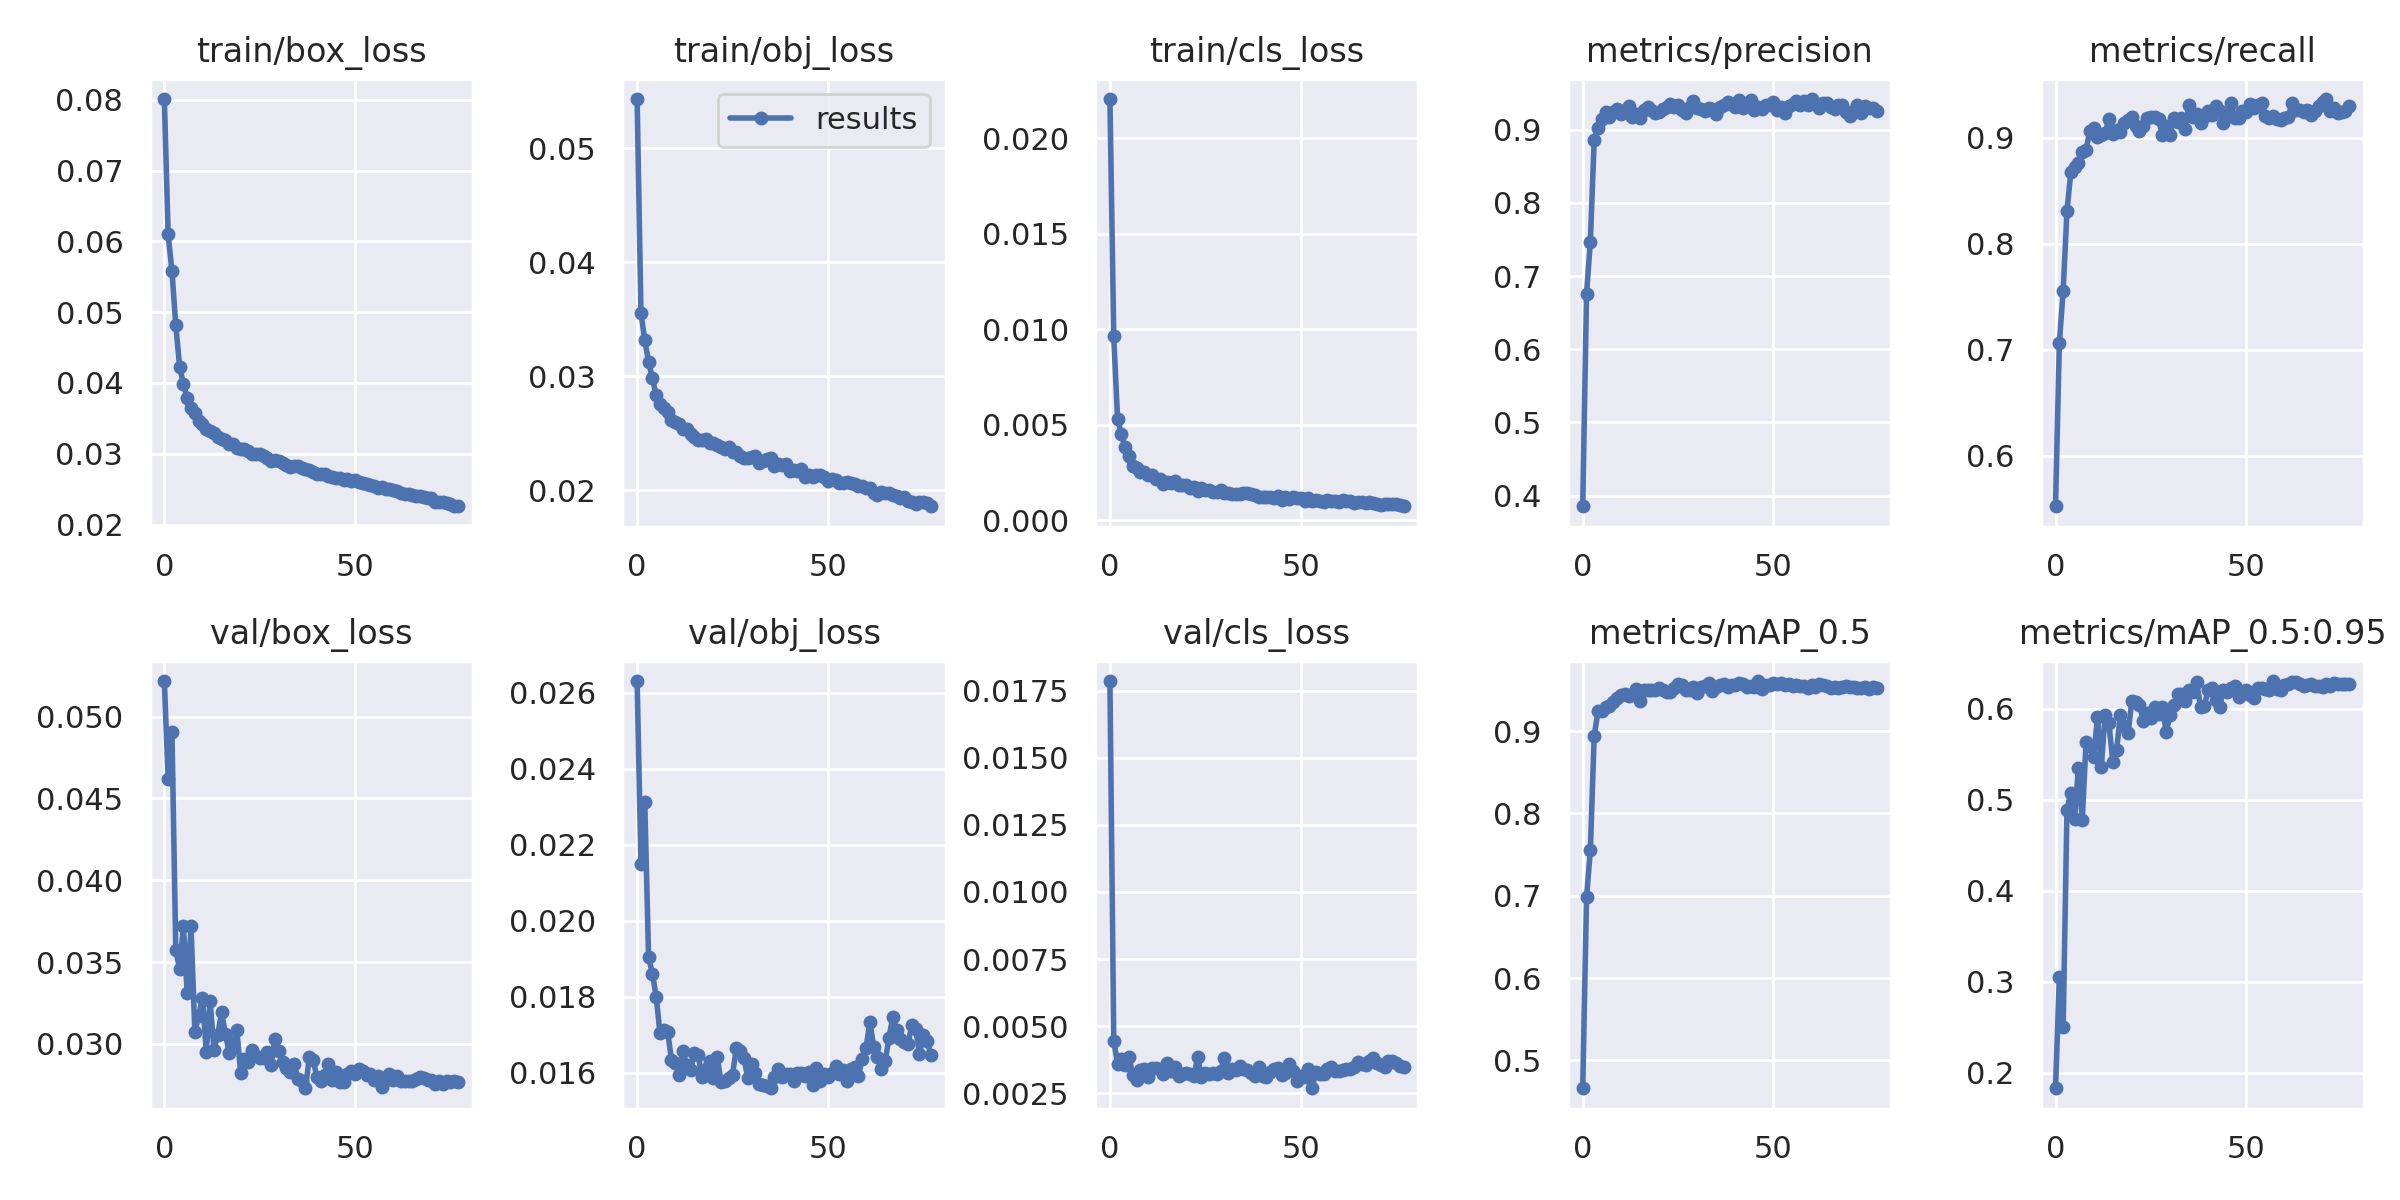

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/BestYOLO/runs/train/results/results.png', width=1000)  # view results.png

### **Visualize Our Training Data with Labels**

In [ ]:
from PIL import Image
def display_images(batch_num, folder_path, size=(12, 6)):
    # Construct the file paths for ground truth and prediction images
    gt_image_path = f"{folder_path}/val_batch{batch_num}_labels.jpg"
    pred_image_path = f"{folder_path}/val_batch{batch_num}_pred.jpg"

    # Open the images using PIL
    gt_image = Image.open(gt_image_path)
    pred_image = Image.open(pred_image_path)

    # Resize images if a size parameter is provided
    if size:
        gt_image = gt_image.resize(size)
        pred_image = pred_image.resize(size)

    # Display images side by side horizontally
    images = [gt_image, pred_image]
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_image = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for image in images:
        new_image.paste(image, (x_offset, 0))
        x_offset += image.width

    new_image.show()


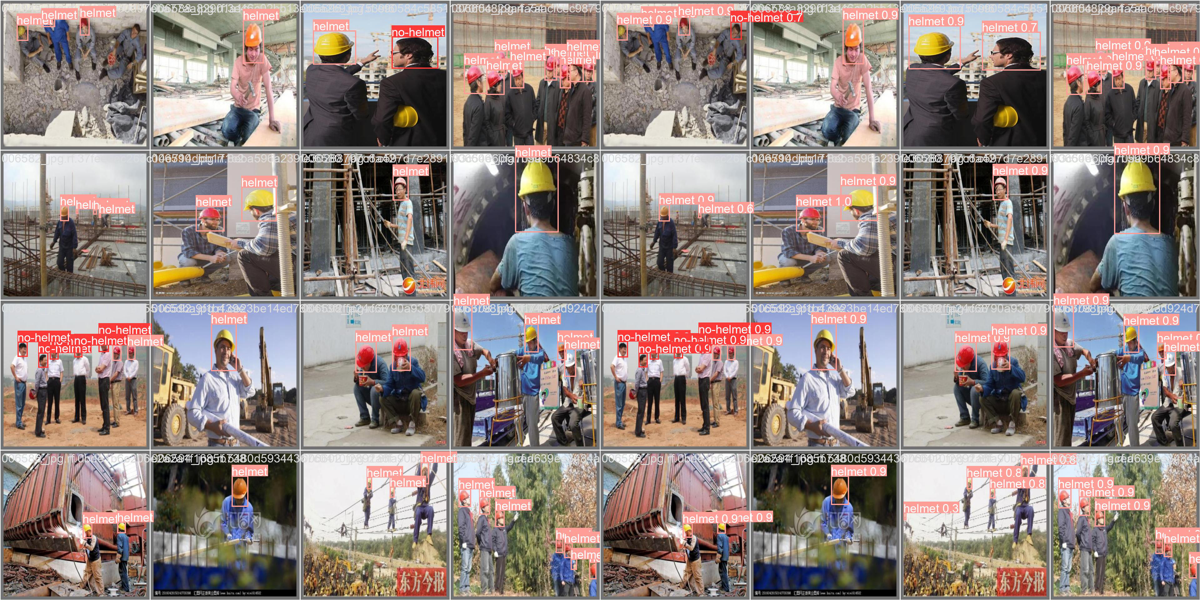

In [ ]:
folder_path = '/content/BestYOLO/runs/train/results'

display_images(0, folder_path, size=(600, 600))

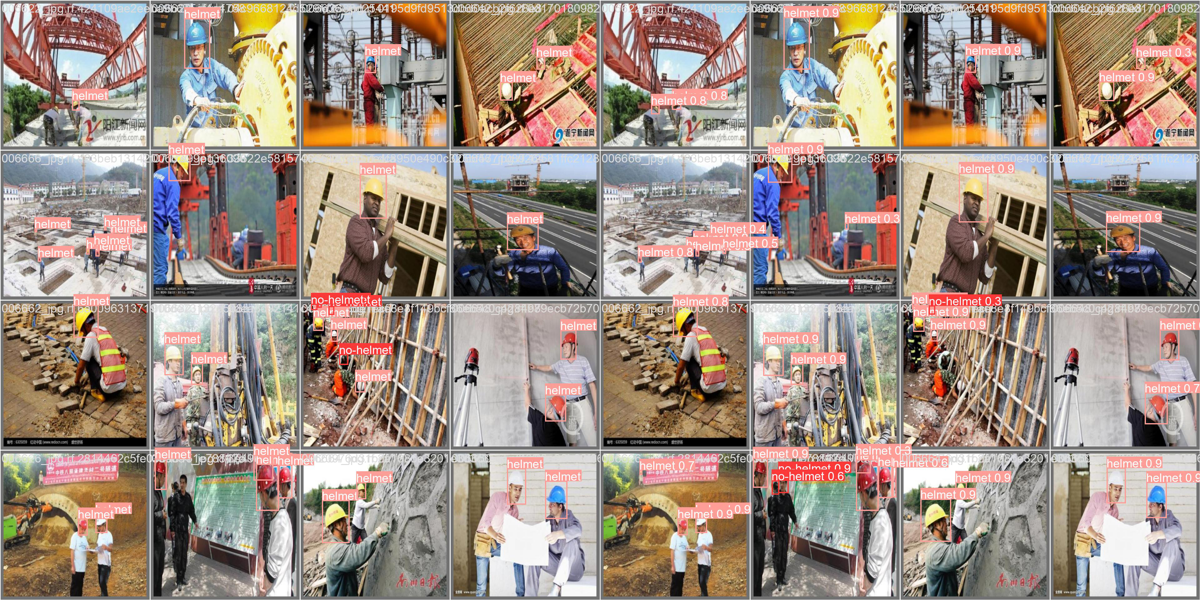

In [ ]:
display_images(1, folder_path, size=(600, 600))

## **Inference with Trained Weights**

In [ ]:
os.chdir('/content/BestYOLO/')

# Run the detect.py script with multiple lines
!python detect.py \
    --weights runs/train/results/weights/best.pt \
    --img 640 \
    --conf 0.4 \
    --source /content/test/images

detect: weights=['runs/train/results/weights/best.pt'], source=/content/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 9417788d Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s_resnet50_SPPCSPC summary: 245 layers, 27099263 parameters, 0 gradients, 71.8 GFLOPs
image 1/353 /content/test/images/005299_jpg.rf.7e8cbce0496f979e698687003725214c.jpg: 640x640 1 helmet, 40.1ms
image 2/353 /content/test/images/005301_jpg.rf.fdc6cb9fe5fe9a5132e80033cb81f049.jpg: 640x640 5 no-helmets, 39.3ms
image 3/353 /content/test/images/005303_jpg.rf.afcdb38c41ef7faad117a0cb8a8f3f3d.jpg: 640x640 1 no-helmet, 4

In [ ]:
import glob
from IPython.display import Image, display

# Define the desired width and height for the resized images
resize_width = 300
resize_height = 300

for imageName in glob.glob('/content/BestYOLO/runs/detect/exp/*.jpg'):
    # Display the image with resized dimensions
    display(Image(filename=imageName, width=resize_width, height=resize_height))
    print("\n")


# **Export Trained Weights for Future Inference**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import torch
import pickle
from datetime import datetime
import shutil

# prompt the user for the model name
model_name = input("Enter the model name: ")

# paths of the models
best_model_path = "/content/BestYOLO/runs/train/results/weights/best.pt"
last_model_path = "/content/BestYOLO/runs/train/results/weights/last.pt"

# load the models
best_model = torch.load(best_model_path)
last_model = torch.load(last_model_path)

# create a new directory in google drive with the current date and time
now = datetime.now()
timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
new_dir_path = f"/content/gdrive/My Drive/{timestamp_str}"
os.makedirs(new_dir_path)

# save the best model in the new directory in .pt format
torch.save(best_model, f"{new_dir_path}/{model_name}-best.pt")

# save the last model in the new directory in .pt format
torch.save(last_model, f"{new_dir_path}/{model_name}-last.pt")

# save the best model in .pkl format
with open(f"{new_dir_path}/{model_name}-best.pkl", 'wb') as f:
    pickle.dump(best_model, f)

# save the last model in .pkl format
with open(f"{new_dir_path}/{model_name}-last.pkl", 'wb') as f:
    pickle.dump(last_model, f)

print(f"Models exported to {new_dir_path} in .pt and .pkl format.")


Enter the model name: resnet50xSPPCSPC-HardHat
Models exported to /content/gdrive/My Drive/2023-05-22_16-50-16 in .pt and .pkl format.
